<img align="left" width="300" height="300" src="https://i.imgur.com/tIKXIG1.jpg">

## 
## 
## Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3

 

## TRABAJO DEL MODULO DE REINFORCEMENT LEARNING
### TEMA: IMPLEMENTACIÓN DE CARTPOLE-V1 EN ENTORNO OPENAI GYM
En este cuaderno se aprecia cómo entrenar a un agente DQN con repetición de experiencia y redes objetivo.

**Basado en el libro de Deep Reinforcement Learning with Python With PyTorch, TensorFlow and OpenAI Gym by Nimish Sanghi**

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline

In [2]:
def make_env(env_name, seed=None):
    # eliminar el contenedor del limite de tiempo del entorno
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [3]:
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(state_dim,)))
        self.model.add(tf.keras.layers.Dense(192, activation='relu'))
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dense(64, activation='relu'))
        self.model.add(tf.keras.layers.Dense(n_actions))
    
    def __call__(self, state_t):
        # pasa el estado en el tiempo t a través de la red para obtener Q(s,a)
        qvalues = self.model(state_t)
        return qvalues

    def get_qvalues(self, states):
        # la entrada es una matriz de los 4 estados en numpy y
        # la salida es Qvals como matriz de 2 acciones en numpy
        qvalues = self.model(states)
        return qvalues.numpy()

    def sample_actions(self, qvalues):
        # acciones de muestra de un lote de q_values usando la política codiciosa de épsilon
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [4]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #número máximo de items en el buffer
        self.buffer =[]  #array que almecena el buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [5]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):
    s = start_state
    sum_rewards = 0

    # Inicia el juego para n_steps y graba las transiciones en el buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(np.array([s]))
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s        
    return sum_rewards, s

In [6]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags, gamma=0.99):

    # obtener q-values para todas las acciones en los estados actuales
    # uso del agent network
    predicted_qvalues = agent(states)

    # calcular  q-values para todas las acciones en los siguientes estados
    # uso del target network
    predicted_next_qvalues = target_network(next_states)
    
    # selecciona q-values para acciones elegidas
    row_indices= tf.range(len(actions))
    indices = tf.transpose([row_indices, actions])
    predicted_qvalues_for_actions = tf.gather_nd(predicted_qvalues, indices)
    
    # calcula Qmax(next_states, actions) usando los siguientes q-values predichos
    next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

    # calcula "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # error medio cuadrado a minimizar
    loss = tf.keras.losses.MSE(target_qvalues_for_actions, predicted_qvalues_for_actions)

    return loss

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(np.array([s]))
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break
        rewards.append(reward)
        
    return np.mean(rewards)

### Búcle principal
Se inicia el entrenamiento sobre el Agente(**DQNAgent**) definido anteriormente

In [8]:
# Establece una semilla(seed)
seed = 13
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [10]:
# configurando env, agent y las target networks
env_name  = 'CartPole-v1'
env       = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state     = env.reset()

#plt.imshow(env.render("rgb_array"))
#state_shape, n_actions = env.observation_space.shape, env.action_space.n

In [11]:
state_dim, n_actions

((4,), 2)

In [12]:
agent          = DQNAgent(state_dim, n_actions, epsilon=1)
target_network = DQNAgent(state_dim, n_actions, epsilon=1)
target_network.model.set_weights(agent.model.get_weights())

In [13]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               960       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 66,946
Trainable params: 66,946
Non-trainable params: 0
_________________________________________________________________


In [14]:
target_network.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 192)               960       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 66,946
Trainable params: 66,946
Non-trainable params: 0
_________________________________________________________________


In [15]:
mean_rw_history = []
td_loss_history = []

In [16]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps) * min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

In [17]:
# inicialización del Optimizador
optimizer            = tf.keras.optimizers.Adam(learning_rate=1e-4)

# configurando la frecuencia del spme frequency para loggind y actualizar la red objetivo
loss_freq            = 20
refresh_target_network_freq = 100
eval_freq            = 1000

# acotar los gradientes
max_grad_norm        = 5000

# estableciendo el epsilon de la exploracion
start_epsilon        = 1
end_epsilon          = 0.05
eps_decay_final_step = 2 * 10**4 # 20000

# configurando algunos parámetros para training
total_steps          = 5 * 10**4 # 50000
timesteps_per_epoch  = 1
batch_size           = 32

In [18]:
# Se completa una experiencia de reproducción con algunas muestras 
# utilizando una política aleatoria completa
exp_replay = ReplayBuffer(10**4) #10000
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)    
    if len(exp_replay) == 10**4: #10000
        break

print(len(exp_replay))

10000


### Entrenando el Agente

tamaño del buffer = 10000, epsilon = 0.05000


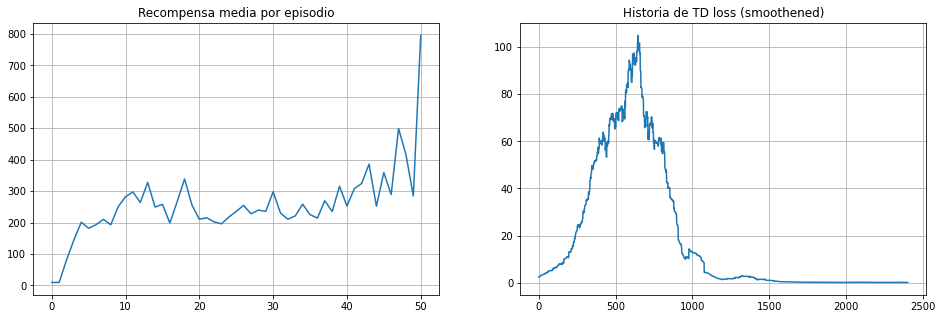

100%|████████████████████████████████████████████████████████████████████████████| 50001/50001 [11:33<00:00, 72.11it/s]


In [19]:
state = env.reset()
for step in trange(total_steps + 1):
    
    # reduciendo la exploración a medida que avanzamos
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # toma timesteps_per_epoch y actualiza la experiencia del replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # entrenar por muestreo el batch_size de datos de la repetición de experiencias
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    
    with tf.GradientTape() as tape:
        # loss = <compute TD loss>
        loss = compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags, gamma=0.99)

    gradients = tape.gradient(loss, agent.model.trainable_variables)
    clipped_grads = [tf.clip_by_norm(g, max_grad_norm) for g in gradients]
    optimizer.apply_gradients(zip(clipped_grads, agent.model.trainable_variables))

    if step % loss_freq == 0:
        td_loss_history.append(loss.numpy())

    if step % refresh_target_network_freq == 0:
        # cargar los pesos del agent dentro de target_network
        target_network.model.set_weights(agent.model.get_weights())

    if step % eval_freq == 0:
        # evaluar el agent
        mean_rw_history.append(evaluate(make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000))

        clear_output(True)
        
        print("tamaño del buffer = %i, epsilon = %.5f" %(len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Recompensa media por episodio")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        # TD: Temporal Difference
        plt.title("Historia de TD loss (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [20]:
final_score = evaluate(make_env(env_name), agent, n_games=30, greedy=True, t_max=1000)

print('puntuación final:', final_score)
print('Bien hecho')

puntuación final: 744.9333333333333
Bien hecho


**Grabando un video del agente entrenado**

In [21]:
def generate_animation(env, agent, save_dir):
    try:
        env = gym.wrappers.Monitor(env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        qvalues = agent.get_qvalues(np.array([state]))
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            print('Recompensa obtenida: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [22]:
# Animando la política aprendida
save_dir='./videos/cartpole/'
env = make_env(env_name)

generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Recompensa obtenida: 300.0
